In [1]:
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils, datasets, models
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)
root_dir = "data\CatvsDOG"

We're using => cuda


In [3]:
image_transforms = {
    "train": transforms.Compose([
        #transforms.Resize((512, 512)),
        transforms.RandomResizedCrop(512),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(20),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()])
}

In [4]:
cat_dog_dataset = datasets.ImageFolder(root = root_dir + "//train",
                                      transform = image_transforms["train"]
                                     )

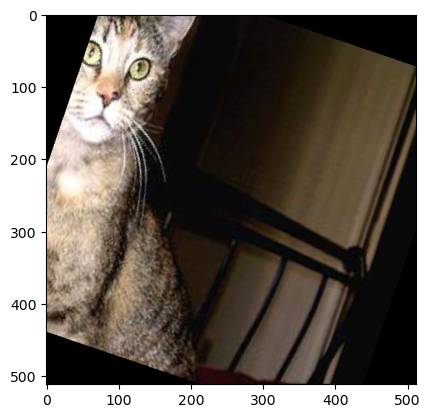

In [5]:
img_ten = cat_dog_dataset[0][0].permute(1,2,0).numpy()
plt.imshow(img_ten)

In [6]:
cat_dog_dataset.class_to_idx

{'cat': 0, 'dog': 1}

In [7]:
catdog_dataset_size = len(cat_dog_dataset)
catdog_dataset_indices = list(range(catdog_dataset_size))

In [8]:
np.random.shuffle(catdog_dataset_indices)

In [9]:
val_split_index = int(np.floor(0.2 * catdog_dataset_size))

In [10]:
train_idx, val_idx = catdog_dataset_indices[val_split_index:], catdog_dataset_indices[:val_split_index]

In [11]:
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [12]:
class_names = cat_dog_dataset.classes
print(class_names)

['cat', 'dog']


In [14]:
train_loader = DataLoader(dataset=cat_dog_dataset, shuffle=False, batch_size=2, sampler=train_sampler)
val_loader = DataLoader(dataset=cat_dog_dataset, shuffle=False, batch_size=2, sampler=val_sampler)
#test_loader = DataLoader(dataset=catdog_dataset_test, shuffle=False, batch_size=1)

In [15]:
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.008)

In [16]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [17]:
accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}

In [18]:
resume = False

In [19]:
if resume:
    model = torch.load('check5.pth')


In [21]:
print("Begin training.")
#for e in tqdm(range(1, 21)):
for epoch in range(5):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_acc = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        y_train_pred = model(X_train_batch)
        train_loss = criterion(y_train_pred, y_train_batch)
        train_acc = binary_acc(y_train_pred, y_train_batch)
        train_loss.backward()
        optimizer.step()
        train_epoch_loss += train_loss.item()
        train_epoch_acc += train_acc.item()
        
    # VALIDATION
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0
        val_epoch_acc = 0
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_acc = binary_acc(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            val_epoch_acc += val_acc.item()
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))
    accuracy_stats['train'].append(train_epoch_acc/len(train_loader))
    accuracy_stats['val'].append(val_epoch_acc/len(val_loader))
    print(f'Epoch {epoch+0:02}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f} | Train Acc: {train_epoch_acc/len(train_loader):.3f}| Val Acc: {val_epoch_acc/len(val_loader):.3f}')
    torch.save(model,'check5.pth')
    print('model saved')

Begin training.
Epoch 00: | Train Loss: 0.28357 | Val Loss: 0.26861 | Train Acc: 86.823| Val Acc: 87.733
model saved
Epoch 01: | Train Loss: 0.24385 | Val Loss: 0.24021 | Train Acc: 89.086| Val Acc: 89.171
model saved
Epoch 02: | Train Loss: 0.22464 | Val Loss: 0.20498 | Train Acc: 90.038| Val Acc: 91.667
model saved
Epoch 03: | Train Loss: 0.20222 | Val Loss: 0.20814 | Train Acc: 90.736| Val Acc: 91.201
model saved
Epoch 04: | Train Loss: 0.19901 | Val Loss: 0.19464 | Train Acc: 90.768| Val Acc: 90.863
model saved


In [ ]:
iter_test = 70
with torch.no_grad():
    model.eval()
    for i , (images, labels) in enumerate (test_loader):
        if i == iter_test: 
            #images = images.view(-1, 512*512).requires_grad_()
            #y_train_pred = model(images.to(device)).squeeze()
            outputs = model(images[0].unsqueeze(0).to(device))
            _, predicted = torch.max(outputs.data, 1)
            #if iter_test == 1:
            print('PREDICTION')
            #print(predicted)
            print(cat_dog_dataset.classes[predicted])
            show_img = images[0].detach().permute(1,2,0).numpy()
            plt.imshow(show_img, cmap='gray')
            break


In [22]:
m= torch.load('check5.pth')
m.eval().cpu()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

tensor([[-0.3280, -1.2743]], grad_fn=<LogSoftmaxBackward0>)
tensor([0])
prediction is:  cat


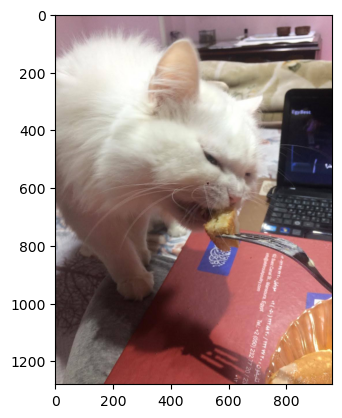

In [38]:
from PIL import Image
import matplotlib.pyplot as plt
def predict_show(path):
    img=Image.open(path)
    img_tensor=image_transforms['test'](img).unsqueeze(0)
    pred = m(img_tensor)

    y_pred_softmax = torch.log_softmax(pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1) 
    print(y_pred_softmax)
    print(y_pred_tags)
    print("prediction is: " , class_names[y_pred_tags])
    plt.imshow(img)
    
    
predict_show('IMG-20200307-WA0025.jpg')

In [24]:
from PIL import Image
import matplotlib.pyplot as plt

In [25]:
img=Image.open('Cat.jpg')

In [28]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [31]:
img_tensor=image_transforms['test'](img)
m(img_tensor.unsqueeze(0))

tensor([[ 8.0066, -8.3973]], grad_fn=<AddmmBackward0>)

In [32]:
class_names

['cat', 'dog']

In [ ]:
model = models.resnet50(pretrained=True)
model

In [ ]:
model = models.resnet152(pretrained=True)
model

In [ ]:
model = models.resnext50_32x4d(pretrained=True)
model